Počet období T = 3  
počáteční zásoba s<sub>0</sub> = 0  
kapacita na období: 60  
  
poptávka od zákazníka dle období:  
p<sub>1</sub> = 40  
p<sub>2</sub> = 60  
p<sub>3</sub> = 30  

výrobní náklady:
c<sub>1</sub> = 10  
c<sub>2</sub> = 15  
c<sub>3</sub> = 20  
  
### Primal
  
x<sub>t</sub> = počet jednotek vyrobených v období **t**  
s<sub>t</sub> = zásoba na konci období **t**  
  
#### Objektivní funkce
minializuj = 10 x<sub>1</sub> + 15 x<sub>2</sub> + 20 x<sub>3 + 2 s<sub>1</sub> + 3 s<sub>2</sub>  
-> co nejméně vyrobit (levné pro mě jako výrobce), co nejméně zásob (výhodné - spoustu jsem toho prodal)    
  
#### Omezení
##### bilance zásob
x<sub>1</sub> - s<sub>1</sub> = 40  
aktuální výroba **-** to co jsem nestihl prodat = **to co musím dodat zákazníkovi**  
s<sub>1</sub> + x<sub>2</sub> - s<sub>2</sub> = 60  
zásoba z minula **+** aktuální výroba **-** to co jsem nestihl prodat = **to co musím dodat zákazníkovi**  
s<sub>2</sub> + x<sub>3</sub> = 30  
zásoba z minula **+** aktuální výroba = **to co musím dodat zákazníkovi** (nebylo potřeba odčítat, co si beru do dalšího období, protože další období nebude)
#### kapacita
x<sub>t</sub> <= 60, t = 1, 2, 3  
teoreticky si mohu vyrobené a neprodené produkty přenášet přes období, nicméně neměly by přesáhnout maximální poptávku.

In [1]:
import pulp

In [2]:
# zadání primalu

T = 3
demand = [40, 60, 30]
prod_cost = [10, 15, 20]
store_cost = [2, 3]
capacity = 60

In [3]:
# model

model = pulp.LpProblem("Vyrobni_Plan_LP_relaxace", pulp.LpMinimize)

In [4]:
# proměnné

x = [pulp.LpVariable(f"x_{t+1}", lowBound=0, upBound=capacity) for t in range(T)]
s = [pulp.LpVariable(f"s_{t+1}", lowBound=0) for t in range(T)]

In [5]:
# Objektivní cíl

model += (
    sum(prod_cost[t] * x[t] for t in range(T)) +
    sum(store_cost[t] * s[t] for t in range(T - 1))
)

In [6]:
# Omezení

constraints = []

constraints.append(model.addConstraint(x[0] - s[0] == demand[0], name="bal_1"))
constraints.append(model.addConstraint(s[0] + x[1] - s[1] == demand[1], name="bal_2"))
constraints.append(model.addConstraint(s[1] + x[2] == demand[2], name="bal_3"))


In [7]:
# řešení

model.solve()

1

In [15]:
model.solve(pulp.PULP_CBC_CMD(msg=1))
for v in model.variables():
    print(v.name, "=", v.varValue)

s_1 = 20.0
s_2 = 20.0
x_1 = 60.0
x_2 = 60.0
x_3 = 10.0


In [17]:
print("\n--- Duální proměnné (stínové ceny) a slacky ---")
if model.status == pulp.LpStatusOptimal:
    for name, constraint in model.constraints.items():
        dual = constraint.pi
        slack = constraint.slack
        dual_str = f"{dual:.2f}" if dual is not None else "N/A"
        slack_str = f"{slack:.2f}" if slack is not None else "N/A"
        print(f"{name}: dual = {dual_str}, slack = {slack_str}")
else:
    print("Model nebyl vyřešen optimálně – nelze zobrazit duální proměnné.")



--- Duální proměnné (stínové ceny) a slacky ---
bal_1: dual = 15.00, slack = -0.00
bal_2: dual = 17.00, slack = -0.00
bal_3: dual = 20.00, slack = -0.00


Jistě! Cílem je minimalizace! A dual mi naznačuje, že nejvýhodnější je opravdu výroba v období 1! Tedy to i nasvědčuje optimální řešení, protože to vyšlo tak, že v prvním obdobím opravdu vyrábím své maximum (60 jednotek na období).  
  
DUAL:  
1) výroba dalšího kusu v období 1 by zvýšila cenu o **15** Kč  
2) výroba dalšího kusu v období 2 by zvýšila cenu o 17! Kč  
3) výroba dalšího kusu v období 3 by zvýšila cenu o 20!! Kč  

Tedy jde vidět, že model je optimální, když vyrábí v období 1 své maximum!

Ale proč 15, když výroba v 1. období stojí jen 10?
Tohle je klíčová otázka – a odpověď je:

🔐 Protože není prostor vyrábět víc bez porušení jiných omezení.
V období 1 už vyrábíš na plnou kapacitu (60).

Pokud bys musel pokrýt o 1 víc, musel bys:

snížit zásoby do období 2 → v období 2 musíš víc vyrábět → to je dražší!

nebo omezit pokrytí v budoucnu → znovu vyšší náklad.

Primal:  
min 10 x<sub>1</sub> + 15 x<sub>2</sub> + 20 x<sub>3 + 2 s<sub>1</sub> + 3 s<sub>2</sub>  
x<sub>1</sub> - s<sub>1</sub> = 40  
s<sub>1</sub> + x<sub>2</sub> - s<sub>2</sub> = 60  
s<sub>2</sub> + x<sub>3</sub> = 30  
  
Duál:
max 40 λ<sub>1</sub> + 60 λ<sub>2</sub> + 30 λ<sub>3</sub> (využij vše)  
λ<sub>1</sub> + μ<sub>1</sub> <= 10 (výroba v 1 období)  
λ<sub>2</sub> - λ<sub>1</sub> + μ<sub>2</sub> <= 15 (výroba v 2 období)  
λ<sub>3</sub> - λ<sub>2</sub> + μ<sub>3</sub> <= 20 (výroba v 3 období)  
-λ<sub>1</sub> + v<sub>1</sub> <= 2 (zásoba po 1 období)   
-λ<sub>2</sub> + v<sub>2</sub> <= 3 (zásoba po 2 období)   



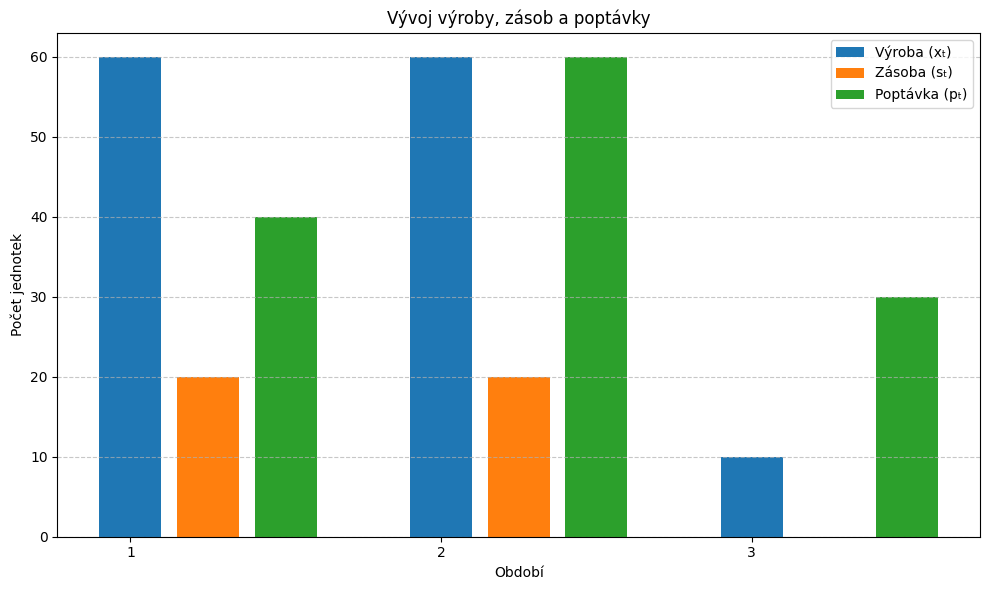

In [18]:
import matplotlib.pyplot as plt

# === VLOŽ SVÁ DATA ZDE ===
periods = [1, 2, 3]  # Období
x = [60, 60, 10]     # Výroba v jednotlivých obdobích (x_t)
s = [20, 20, 0]      # Zásoba na konci období (s_t)
p = [40, 60, 30]     # Poptávka od zákazníků v jednotlivých obdobích (p_t)

# === VYKRESLENÍ ===
plt.figure(figsize=(10, 6))

# Výroba
plt.bar(periods, x, width=0.2, label='Výroba (xₜ)', align='center')

# Zásoba na konci
plt.bar([t + 0.25 for t in periods], s, width=0.2, label='Zásoba (sₜ)', align='center')

# Poptávka
plt.bar([t + 0.5 for t in periods], p, width=0.2, label='Poptávka (pₜ)', align='center')

# Popisky a styly
plt.xticks(periods)
plt.xlabel("Období")
plt.ylabel("Počet jednotek")
plt.title("Vývoj výroby, zásob a poptávky")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
